# Setting

## Library

In [ ]:
import pandas as pd
import numpy as np
import math

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import random
import os
from tqdm.notebook import tqdm

In [ ]:
from sklearn.ensemble import IsolationForest

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score # 정확도
from sklearn.metrics import precision_score # 정밀도
from sklearn.metrics import recall_score # 재현율
from sklearn.metrics import f1_score # F1-Score
from sklearn.metrics import confusion_matrix

In [ ]:
import warnings
warnings.filterwarnings('ignore')

## Seed

In [ ]:
def my_seed_everywhere(seed):
    random.seed(seed) # random
    np.random.seed(seed) # numpy
    os.environ["PYTHONHASHSEED"] = str(seed) # os
    print(f'고정된 Seed : {seed}')

In [ ]:
my_seed_everywhere(42)

고정된 Seed : 42


# Data Set

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [309]:
path_file = '/content/drive/MyDrive/UNIST/AICP/data/dynmom_dat.csv'

df = pd.read_csv(path_file)

# Preprocessing

In [310]:
def preprocessing(data, used=None):
  # 'DATE'를 칼럼 대신 인덱스로 사용
  data.index = data['DATE']
  data = data.drop(columns='DATE')
  print("'DATE'를 칼럼 대신 인덱스로 사용")

  # 결측치 제거 및 모델 학습에 불필요한 칼럼 제거
  data = data.dropna()
  data = data.drop(columns=['winner', 'loser', 'form_date'])
  print("결측치 제거 및 모델 학습에 불필요한 칼럼 제거 ('winner', 'loser', 'form_date')")

  if used != None:
    used += ['wml']
    D = ', '.join(used)
    data = data[used]
    print(f"훈련에 사용되는 변수 들 : {D}")

  return data

In [311]:
dynmom = preprocessing(df,
                       used=['mvol_t_1', 'mvol_t_2', 'mvol_t_3', 'mvol_t_4' , 'mvol_t_5', 'mvol_t_6',
                             'cum_winner_t_2_4', 'cum_winner_t_5_8', 'cum_winner_t_9_12',
                             'cum_loser_t_2_4', 'cum_loser_t_5_8', 'cum_loser_t_9_12'])

'DATE'를 칼럼 대신 인덱스로 사용
결측치 제거 및 모델 학습에 불필요한 칼럼 제거 ('winner', 'loser', 'form_date')
훈련에 사용되는 변수 들 : mvol_t_1, mvol_t_2, mvol_t_3, mvol_t_4, mvol_t_5, mvol_t_6, cum_winner_t_2_4, cum_winner_t_5_8, cum_winner_t_9_12, cum_loser_t_2_4, cum_loser_t_5_8, cum_loser_t_9_12, wml


# Modeling

In [312]:
def define_pos_wml(df, purpose):

  if purpose == 'train':
    cond_wml = (df['wml']>=0)
    df.loc[cond_wml, 'pos_wml'] = 0
    df.loc[~cond_wml, 'pos_wml'] = 1

  if purpose == 'test':
    cond_wml = (df['wml']>=0)
    df.loc[cond_wml, 'pos_wml'] = 0
    df.loc[~cond_wml, 'pos_wml'] = 1


  return df

In [337]:
def Roling_Windows(data, window_size, method, model, scaling):

  # 학습 및 테스트 데이터 정보 & 실제값과 예측값 정보 수집
  result_dict = {
      'TRAIN_START_DATE':[], # 훈련 데이터 시작 지점
      'TRAIN_END_DATE':[], # 훈련 데이터 마지막 지점
      'TEST_DATE':[], # 테스트 데이터 지점
      'wml':[], # wml 값
      'dynamic_momentum':[], # 다이나믹 모멘텀 값
      'dynamic_leverage':[], # 추론된 Target 확률값
      'anomaly_score':[],
      'Actual_POS_WML':[], # 실제 Target 값 (0 or 1)
      'static_leverage':[], # 추론된 Target 값 (0 or 1)
                }

  df_feature = pd.DataFrame()

  # 모델 학습이 종료되는 지점 설정
  end = data.shape[0] - window_size

  print('*'*50)
  print('설정된 Model의 하이퍼파리미터 : \n')
  for p, v in zip(model.get_params(deep=True).keys(), model.get_params(deep=True).values()):
    print(f'   {p} : {v}')
  print()
  print('*'*50)

  for i in tqdm(range(end)):

    # 모델 학습 중지
    if i == end:
      print('Prediction using machine learning has ended.')
      break

    # Rolling Fixed Window
    if method == 'Fixed':
      MODEL = model
      train = data.iloc[0+i:window_size+i]
      TRAIN = define_pos_wml(train, purpose='train')
      TRAIN = TRAIN.loc[TRAIN['pos_wml']==0] # 비지도 학습 : 주석 처리하고 모델 학습 시 label 입력하지 않을 것

    # Rolling Expanding Window
    elif method == 'Expanding':
      MODEL = model
      train = data.iloc[0:window_size+i]
      TRAIN = define_pos_wml(train, purpose='train')
      TRAIN = TRAIN.loc[TRAIN['pos_wml']==0] # 비지도 학습 : 주석 처리하고 모델 학습 시 label 입력하지 않을 것

    # 'method' 잘못입력한 경우
    else:
      print("Make sure to set the method to either 'Fixed' or 'Expanding'.")
      break

    # 테스트 데이터 설정
    test = data.iloc[[window_size+i]]
    TEST = define_pos_wml(test, purpose='test')

    # Features와 Target 구분
    X_train = TRAIN.drop(columns=['pos_wml', 'wml'])
    y_train = TRAIN['pos_wml']

    X_test = TEST.drop(columns=['pos_wml', 'wml'])
    y_test = TEST['pos_wml']

    wml_test = list(test['wml'])

    # 모델 학습 및 추론
    MODEL.fit(X_train, y_train) # 지도 or 준지도
    #MODEL.fit(X_train) # 비지도 학습 시 사용
    pred_test = MODEL.predict(X_test)
    if pred_test == -1:
      pred_test = 1
    else:
      pred_test = 0

    prob_test = MODEL.decision_function(X_test)

    # 학습 및 테스트 데이터 정보 & 실제값과 예측값 정보 수집
    result_dict['TRAIN_START_DATE'].append(train.index[0])
    result_dict['TRAIN_END_DATE'].append(train.index[-1])
    result_dict['TEST_DATE'].append(str(test.index[0]))

    result_dict['wml'].append(wml_test[0])

    dynamic_momentum = (sigmoid(scaling*prob_test[0])) * wml_test[0]
    result_dict['dynamic_momentum'].append(dynamic_momentum)

    result_dict['Actual_POS_WML'].append(int(list(y_test)[0]))
    result_dict['static_leverage'].append(pred_test)
    result_dict['dynamic_leverage'].append(sigmoid(scaling*prob_test[0]))
    result_dict['anomaly_score'].append(prob_test[0])

  result = pd.DataFrame(result_dict)
  result = result.set_index('TEST_DATE')

  # 학습 및 테스트 데이터 정보, 실제값과 예측값 정보, 변수 중요도 정보
  return result

In [338]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

# Inference

In [452]:
ISO_Param={'n_estimators':50,
           'max_samples':1.0,
           'contamination':'auto',
           'max_features':0.4}
ISO = IsolationForest(**ISO_Param, random_state=42)

In [453]:
Fixed_ISO_Result = Roling_Windows(data=dynmom, # 사용할 데이터
                                  window_size=240, # window size (훈련 데이터 셋 크기)
                                  method='Fixed', # Rolling Winodw Method (Fixed or Expanding)
                                  model=ISO,
                                  scaling=30)

**************************************************
설정된 Model의 하이퍼파리미터 : 

   bootstrap : False
   contamination : auto
   max_features : 0.4
   max_samples : 1.0
   n_estimators : 50
   n_jobs : None
   random_state : 42
   verbose : 0
   warm_start : False

**************************************************


  0%|          | 0/906 [00:00<?, ?it/s]

In [454]:
Fixed_ISO_Result.head(10)

,TRAIN_START_DATE,TRAIN_END_DATE,wml,dynamic_momentum,dynamic_leverage,anomaly_score,Actual_POS_WML,static_leverage
TEST_DATE,,,,,,,,
19470731,19270730,19470630,-0.052114,-0.050711,0.973069,0.119573,1,0
19470829,19270831,19470731,0.030634,0.029876,0.975250,0.122462,0,0
19470930,19270930,19470829,-0.038537,-0.037822,0.981423,0.132235,1,0
19471031,19271031,19470930,0.044931,0.044282,0.985549,0.140747,0,0
19471129,19271130,19471031,0.053920,0.053321,0.988886,0.149614,0,0
19471231,19271231,19471129,0.057494,0.056879,0.989311,0.150927,0,0
19480131,19280131,19471231,-0.045630,-0.045110,0.988600,0.148755,1,0
19480228,19280229,19480131,0.044267,0.043737,0.988034,0.147120,0,0
19480331,19280331,19480228,-0.018584,-0.018329,0.986231,0.142383,1,0


In [455]:
Fixed_ISO_Result[['anomaly_score']].describe()

,anomaly_score
count,906.000000
mean,0.062002
std,0.081215
min,-0.225134
25%,0.019833
50%,0.087508
75%,0.122235
max,0.170584


In [456]:
Fixed_ISO_Result.loc[Fixed_ISO_Result['static_leverage']==0]

,TRAIN_START_DATE,TRAIN_END_DATE,wml,dynamic_momentum,dynamic_leverage,anomaly_score,Actual_POS_WML,static_leverage
TEST_DATE,,,,,,,,
19470731,19270730,19470630,-0.052114,-0.050711,0.973069,0.119573,1,0
19470829,19270831,19470731,0.030634,0.029876,0.975250,0.122462,0,0
19470930,19270930,19470829,-0.038537,-0.037822,0.981423,0.132235,1,0
19471031,19271031,19470930,0.044931,0.044282,0.985549,0.140747,0,0
19471129,19271130,19471031,0.053920,0.053321,0.988886,0.149614,0,0
...,...,...,...,...,...,...,...,...
20220331,20020328,20220228,0.016722,0.015700,0.938906,0.091077,0,0
20220429,20020430,20220331,0.146050,0.130909,0.896330,0.071903,0,0
20220531,20020531,20220429,0.066120,0.061622,0.931978,0.087249,0,0


In [457]:
Fixed_ISO_Result.loc[Fixed_ISO_Result['static_leverage']==1]

,TRAIN_START_DATE,TRAIN_END_DATE,wml,dynamic_momentum,dynamic_leverage,anomaly_score,Actual_POS_WML,static_leverage
TEST_DATE,,,,,,,,
19620831,19420831,19620731,-0.028629,-0.009829,0.343322,-0.021617,1,1
19621231,19421231,19621130,0.063835,0.005735,0.089848,-0.077183,0,1
19660331,19460330,19660228,0.033817,0.012436,0.367743,-0.018064,0,1
19660429,19460430,19660331,0.034661,0.010590,0.305539,-0.027369,0,1
19660531,19460531,19660429,-0.071461,-0.020728,0.290056,-0.029837,1,1
...,...,...,...,...,...,...,...,...
20220831,20020830,20220729,-0.021856,-0.007554,0.345627,-0.021277,1,1
20220930,20020930,20220831,0.099930,0.041256,0.412845,-0.011741,0,1
20221031,20021031,20220930,0.129322,0.064552,0.499156,-0.000113,0,1


# Result

In [458]:
def cum_return_sharpe_ratio(data, dynamic=True):

  if dynamic == True:
    weight = 'dynamic_leverage'
  else:
    weight = 'static_leverage'

  # 머신러닝 적용되지 않은 경우 Sharpe Ratio
  w_S = (data['wml'].mean()/data['wml'].std()) * math.sqrt(12)
  print('ORG Sharpe Ratio : {}'.format(w_S))

  # 머신러닝 적용된 경우 Sharpe Ratio
  S = (data['dynamic_momentum'].mean()/data['dynamic_momentum'].std())*math.sqrt(12)
  print('ML Sharpe Ratio : {}\n'.format(S))

  # 머신러닝 적용된 경우 누적 수익률
  data['cum_return'] = (1 + data.dynamic_momentum).cumprod() - 1

  print('\n최근 누적 수익률\n')
  latly_10 = data[['cum_return']].sort_index(ascending=False).head(5)
  for i, r in zip(latly_10.index, latly_10['cum_return']):
    i = str(i)
    print('  {}년-{}월 -> {:0.2f}'.format(i[:4], i[4:6], r))

  print('\n누적 수익률 가장 높았던 순간 Top 10\n')
  top_10 = data[['cum_return']].sort_values(by='cum_return', ascending=False).head(10)
  rank = 1
  for i, r in zip(top_10.index, top_10['cum_return']):
    i = str(i)
    print('  {}등 : {}년-{}월 -> {:0.2f}'.format(rank, i[:4], i[4:6], r))
    rank += 1
  print()

  # 머신러닝 적용되지 않은 경우 누적 수익률
  without_machine = pd.DataFrame(data['wml'])
  without_machine['wml'] = (1 + without_machine.wml).cumprod() - 1
  without_machine.columns = ['cum_return']

  # 머신러닝 여부에 따른 누적 수익률 비교
  plt.figure(figsize=(13, 6))
  plt.title('Comparing Cumulative Returns with and without Machine Learning')
  sns.lineplot(data=data, x=data.index, y=data['cum_return'], label='With_ML', color='darkgreen', lw=3)
  sns.lineplot(data=without_machine, x=without_machine.index, y=without_machine['cum_return'], label='Original', color='gray', lw=3)
  plt.xticks([data.index[i] for i in range(0,len(data.index), 12)])
  plt.tick_params(axis='x',
                  direction='out',
                  labelrotation=45,
                  length=1,
                  pad=10,
                  labelsize=5,
                  width=5)

  plt.show()

In [459]:
def statistic_information(data, col):
  statistic = data[[col]].describe().T
  statistic['var'] = data[col].var()
  statistic['1%'] = data[col].quantile(0.01)
  statistic['99%'] = data[col].quantile(0.99)

  statistic = statistic[['count', 'mean', 'var', 'std',
                         'min', '1%', '25%', '50%',
                         '75%',  '99%', 'max']]

  return statistic

In [460]:
def plot_predict_result(data):
  print('\nPerformance results of the model\n')

  # Confusion Matrix & etc
  print(classification_report(data['Actual_POS_WML'], data['static_leverage']))

  # Accuracy, Precision, Recall, F1 Score
  accuracy = accuracy_score(data['Actual_POS_WML'], data['static_leverage'])
  precision = precision_score(data['Actual_POS_WML'], data['static_leverage'])
  recall = recall_score(data['Actual_POS_WML'], data['static_leverage'])
  F1_score = f1_score(data['Actual_POS_WML'], data['static_leverage'])

  print(f'\naccuracy : {accuracy}')
  print(f'\nprecision : {precision}')
  print(f'\nrecall : {recall}')
  print(f'\nF1-Score : {F1_score}\n')
  colormap = sns.color_palette("Greens")

  # Visualization Confusion Matrix
  confusion = confusion_matrix(data['Actual_POS_WML'], data['static_leverage'])
  sns.heatmap(confusion, annot=True, fmt='g', cmap=colormap)
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')
  plt.title(f'Confusion Matrix')

  plt.show()

  # ACTUAL = PRED = 1
  cond = (data['Actual_POS_WML'] == 1) & (data['static_leverage'] == 1)
  cond_data = data.loc[cond]
  print('\nACTUAL = PRED = 1\n')
  plt.figure(figsize=(15, 5))
  plt.title('WML in ACTUAL = PRED = 1')
  sns.barplot(data=cond_data,
              x=cond_data.index,
              y='wml')
  plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)
  plt.show()
  info = statistic_information(cond_data, 'wml')
  display(info)

  print()
  plt.figure(figsize=(15, 5))
  plt.title('Dynamic Momentum in ACTUAL = PRED = 1')
  sns.barplot(data=cond_data,
              x=cond_data.index,
              y='dynamic_momentum')
  plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)
  info = statistic_information(cond_data, 'dynamic_momentum')
  display(info)


  print()
  print('-'*80)
  print()

  # ACTUAL = PRED = 0
  cond = (data['Actual_POS_WML'] == 0) & (data['static_leverage'] == 0)
  cond_data = data.loc[cond]
  print('\nACTUAL = PRED = 0\n')
  plt.figure(figsize=(15, 5))
  plt.title('WML in ACTUAL = PRED = 0')
  sns.barplot(data=cond_data,
              x=cond_data.index,
              y='wml')
  plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)
  plt.show()
  info = statistic_information(cond_data, 'wml')
  display(info)

  print()
  plt.figure(figsize=(15, 5))
  plt.title('Dynamic Momentum in ACTUAL = PRED = 0')
  sns.barplot(data=cond_data,
              x=cond_data.index,
              y='dynamic_momentum')
  plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)
  info = statistic_information(cond_data, 'dynamic_momentum')
  display(info)

  print()
  print('-'*80)
  print()

  # ACTUAL = 0 & PRED = 1
  cond = (data['Actual_POS_WML'] == 0) & (data['static_leverage'] == 1)
  cond_data = data.loc[cond]
  print('\nACTUAL = 0 & PRED = 1\n')
  plt.figure(figsize=(15, 5))
  plt.title('WML in ACTUAL = 0 & PRED = 1')
  sns.barplot(data=cond_data,
              x=cond_data.index,
              y='wml')
  plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)
  plt.show()
  info = statistic_information(cond_data, 'wml')
  display(info)

  print()
  plt.figure(figsize=(15, 5))
  plt.title('Dynamic Momentum in ACTUAL = 0 & PRED = 1')
  sns.barplot(data=cond_data,
              x=cond_data.index,
              y='dynamic_momentum')
  plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)
  plt.show()
  info = statistic_information(cond_data, 'dynamic_momentum')
  display(info)

  print()
  print('-'*80)
  print()

  # ACTUAL = 1 & PRED = 0
  cond = (data['Actual_POS_WML'] == 1) & (data['static_leverage'] == 0)
  cond_data = data.loc[cond]
  print('\nACTUAL = 1 &  PRED = 0\n')
  plt.figure(figsize=(15, 5))
  plt.title('WML in ACTUAL = 1 & PRED = 0')
  sns.barplot(data=cond_data,
              x=cond_data.index,
              y='wml')
  plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)
  plt.show()
  info = statistic_information(cond_data, 'wml')
  display(info)

  print()
  plt.figure(figsize=(15, 5))
  plt.title('Dynamic Momentum in ACTUAL = 1 & PRED = 0')
  sns.barplot(data=cond_data,
              x=cond_data.index,
              y='dynamic_momentum')
  plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)
  plt.show()
  info = statistic_information(cond_data, 'dynamic_momentum')
  display(info)

In [461]:
def plot_dynamic_momentum(data):

  print('\nTop 5 dyn_mom\n')
  display(data.sort_values(by='dynamic_momentum', ascending=False).head(5))

  print('\nBottom 5 dyn_mom\n')
  display(data.sort_values(by='dynamic_momentum', ascending=True).head(5))
  print()

  plt.figure(figsize=(13,8))
  plt.title('Histogram of Dynamic Momentum')
  sns.histplot(data=data, x='dynamic_momentum', kde=True)
  plt.show()
  print()

  info = statistic_information(data, 'dynamic_momentum')
  display(info)
  print()

  plt.figure(figsize=(13,8))
  plt.title('Histogram of Dynamic Leverage')
  sns.histplot(data=data, x='dynamic_leverage', kde=True)
  plt.show()
  print()

  info = statistic_information(data, 'dynamic_leverage')
  display(info)
  print()

  plt.figure(figsize=(13,8))
  plt.title('Histogram of Anomaly Score')
  sns.histplot(data=data, x='anomaly_score', kde=True)
  plt.show()
  print()

  info = statistic_information(data, 'anomaly_score')
  display(info)
  print()

  plt.figure(figsize=(15, 5))
  plt.title('Line Plot of Dynamic Momentum')
  sns.lineplot(data=data, x=data.index, y='dynamic_momentum', marker='o', markersize=0.5 ,linewidth=2)
  plt.xticks([data.index[i] for i in range(0, len(data.index), 36)],
             labels=[data.index[i][:4] for i in range(0, len(data.index), 36)])
  plt.tick_params(axis='x',
                  direction='out',
                  labelrotation=45,
                  length=1,
                  pad=10,
                  labelsize=13,
                  width=5)
  plt.show()
  print()

  plt.figure(figsize=(15, 5))
  plt.title('Dynamic Leverage vs. WML')
  sns.lineplot(data=data, x=data.index, y='wml', label='WML',linewidth=0.5, color='orange')
  sns.lineplot(data=data, x=data.index, y='dynamic_leverage', label='Dynamic Leverage' ,linewidth=0.5, color='green')

  plt.xticks([data.index[i] for i in range(0, len(data.index), 36)],
             labels=[data.index[i][:4] for i in range(0, len(data.index), 36)])
  plt.tick_params(axis='x',
                  direction='out',
                  labelrotation=45,
                  length=1,
                  pad=10,
                  labelsize=10,
                  width=5)
  plt.legend()
  plt.show()

## Sharpe Ratio & Cumulative Return

ORG Sharpe Ratio : 0.7293406994683723
ML Sharpe Ratio : 1.0021869909628087


최근 누적 수익률

  2022년-12월 -> 102158.03
  2022년-11월 -> 100882.98
  2022년-10월 -> 99581.51
  2022년-09월 -> 93543.08
  2022년-08월 -> 89836.78

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2022년-12월 -> 102158.03
  2등 : 2022년-11월 -> 100882.98
  3등 : 2022년-10월 -> 99581.51
  4등 : 2022년-09월 -> 93543.08
  5등 : 2022년-07월 -> 90520.57
  6등 : 2022년-08월 -> 89836.78
  7등 : 2022년-06월 -> 87679.67
  8등 : 2022년-05월 -> 86718.68
  9등 : 2022년-04월 -> 81684.99
  10등 : 2020년-03월 -> 74177.15



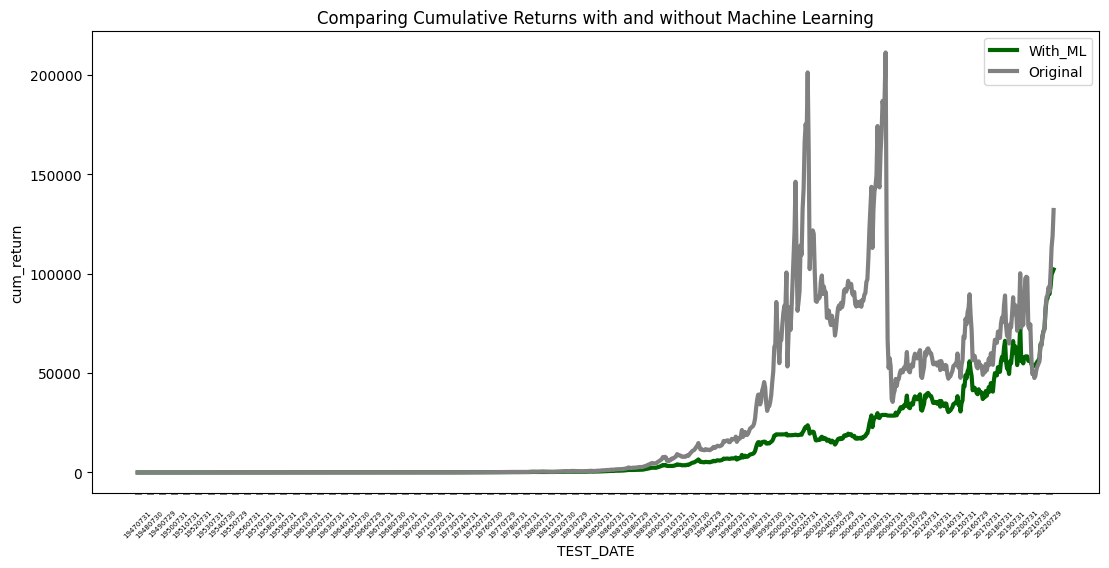

In [462]:
cum_return_sharpe_ratio(data=Fixed_ISO_Result,
                        dynamic=True)

## Confusion Matrix


Performance results of the model

              precision    recall  f1-score   support

           0       0.67      0.82      0.74       590
           1       0.42      0.25      0.31       316

    accuracy                           0.62       906
   macro avg       0.55      0.53      0.53       906
weighted avg       0.58      0.62      0.59       906


accuracy : 0.6192052980132451

precision : 0.42245989304812837

recall : 0.25

F1-Score : 0.31411530815109345



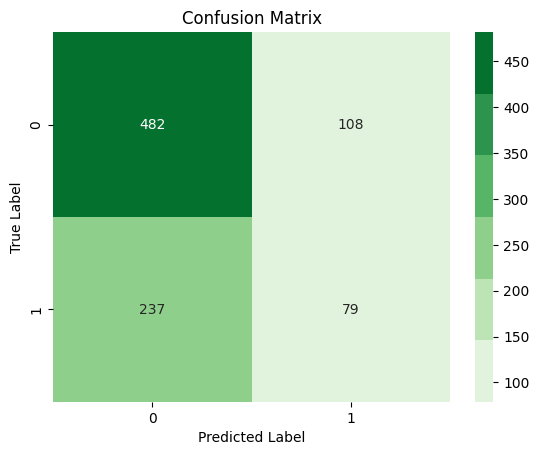


ACTUAL = PRED = 1



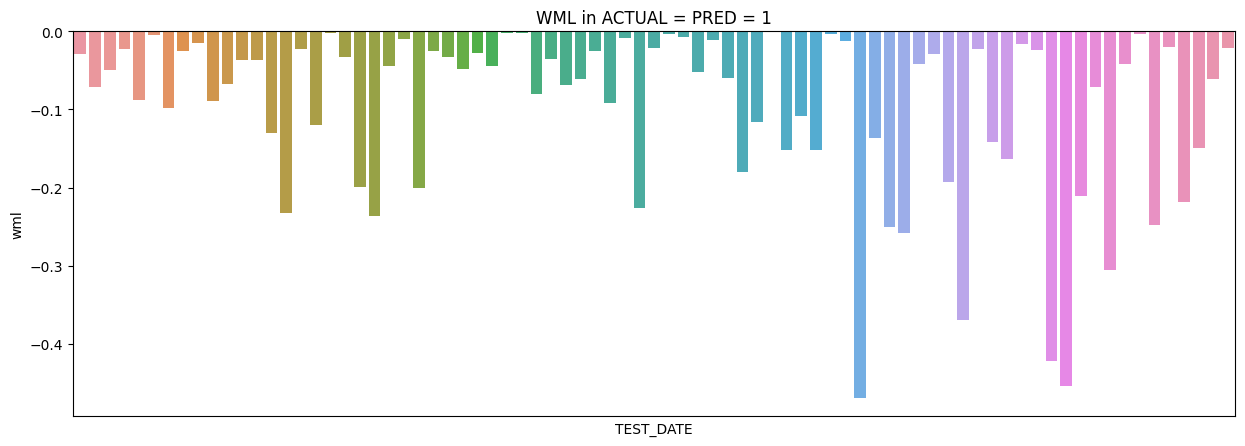

,count,mean,var,std,min,1%,25%,50%,75%,99%,max
wml,79.0,-0.099522,0.012032,0.109692,-0.469903,-0.457771,-0.150354,-0.052071,-0.022327,-0.001309,-0.000132


,count,mean,var,std,min,1%,25%,50%,75%,99%,max
dynamic_momentum,79.0,-0.016716,0.000756,0.027493,-0.128973,-0.110773,-0.015255,-0.005816,-0.001187,-0.000009,-0.000004



--------------------------------------------------------------------------------


ACTUAL = PRED = 0



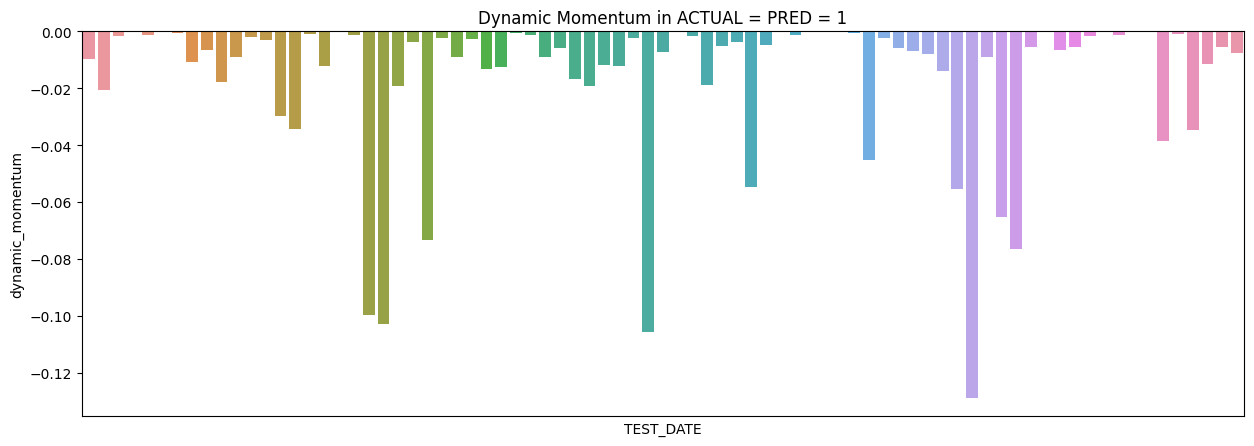

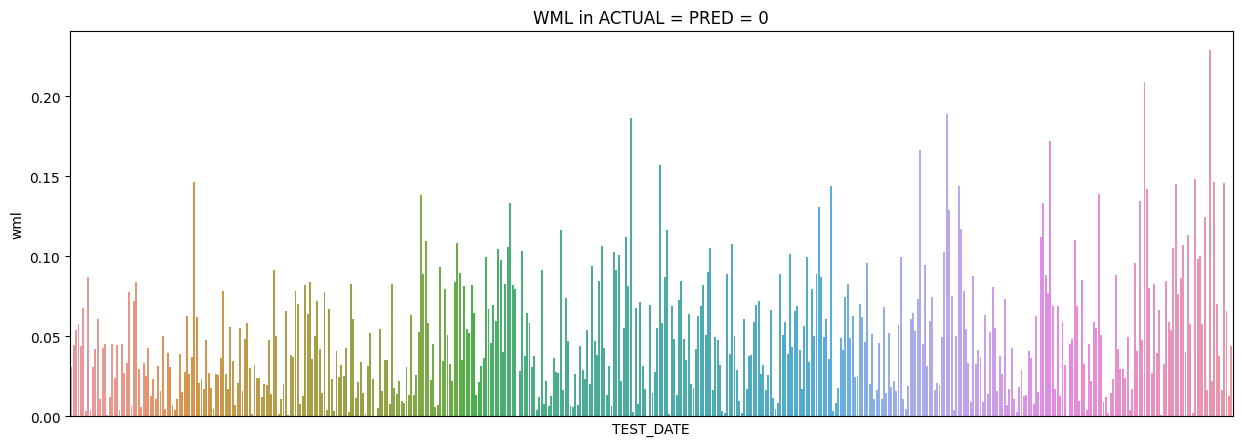

,count,mean,var,std,min,1%,25%,50%,75%,99%,max
wml,482.0,0.048465,0.001428,0.037785,0.000007,0.000776,0.018093,0.041225,0.06915,0.1677,0.22913


,count,mean,var,std,min,1%,25%,50%,75%,99%,max
dynamic_momentum,482.0,0.043699,0.001164,0.034125,0.000004,0.000748,0.016212,0.037357,0.061788,0.143834,0.21151



--------------------------------------------------------------------------------


ACTUAL = 0 & PRED = 1



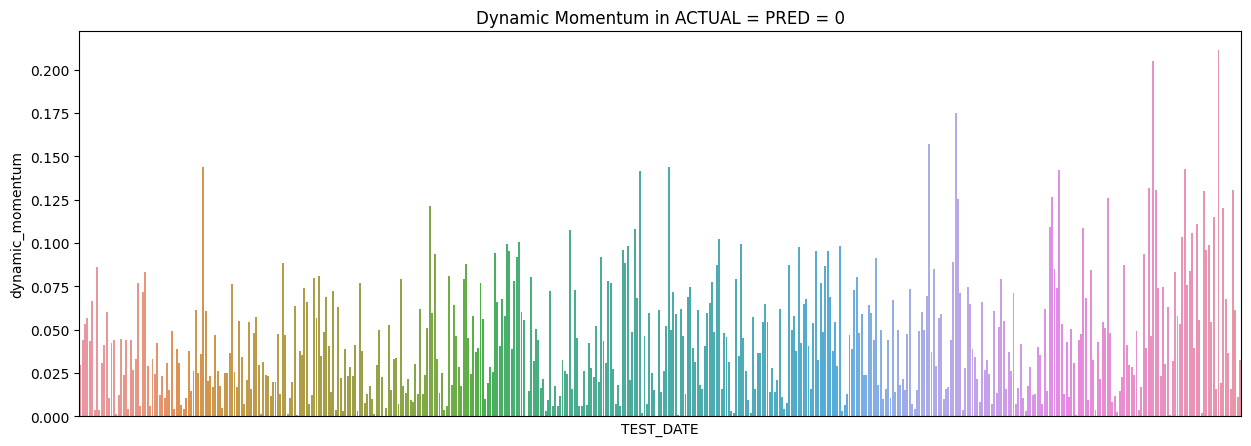

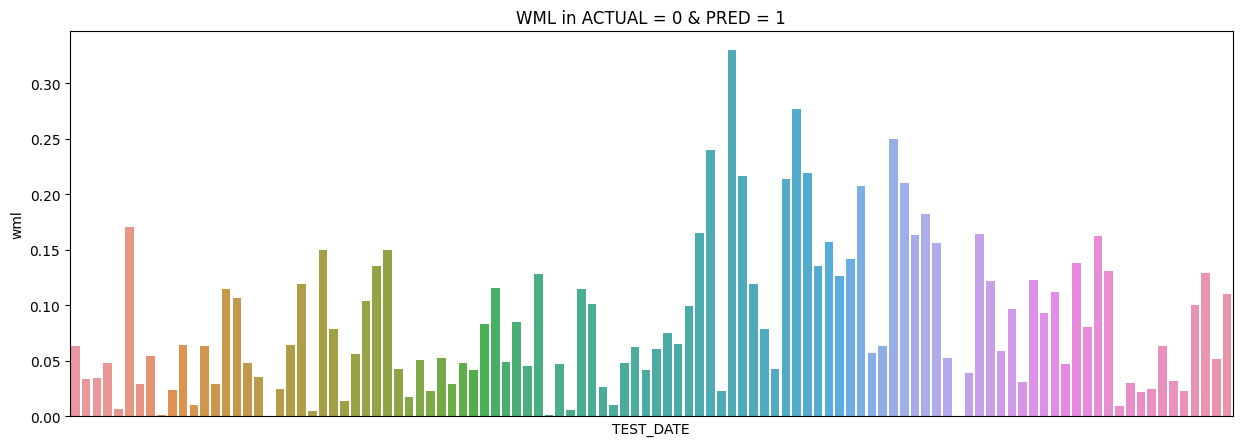

,count,mean,var,std,min,1%,25%,50%,75%,99%,max
wml,108.0,0.085532,0.004511,0.067166,0.000627,0.000713,0.03445,0.063289,0.123847,0.27504,0.330163


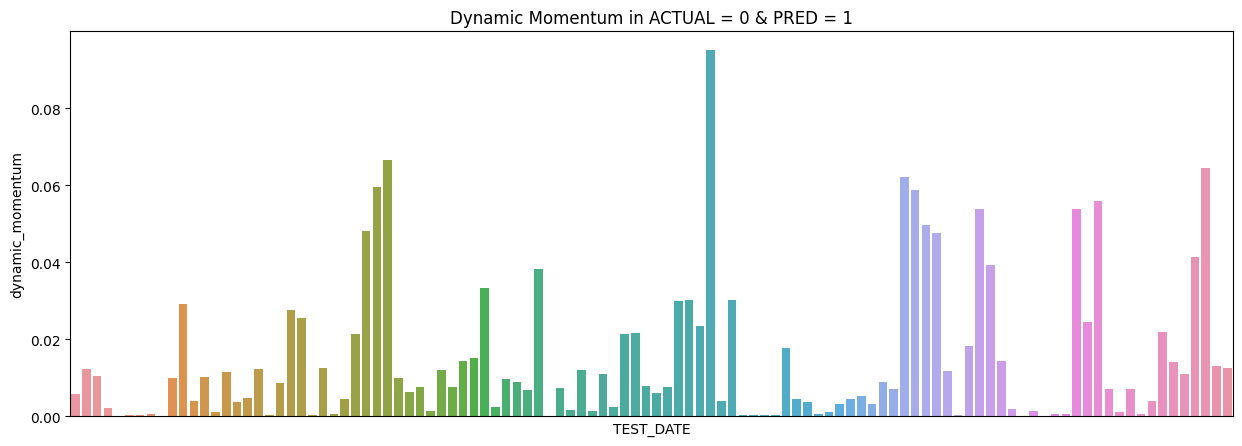

,count,mean,var,std,min,1%,25%,50%,75%,99%,max
dynamic_momentum,108.0,0.015168,0.000356,0.018877,0.000084,0.000142,0.001847,0.007789,0.021358,0.06639,0.095156



--------------------------------------------------------------------------------


ACTUAL = 1 &  PRED = 0



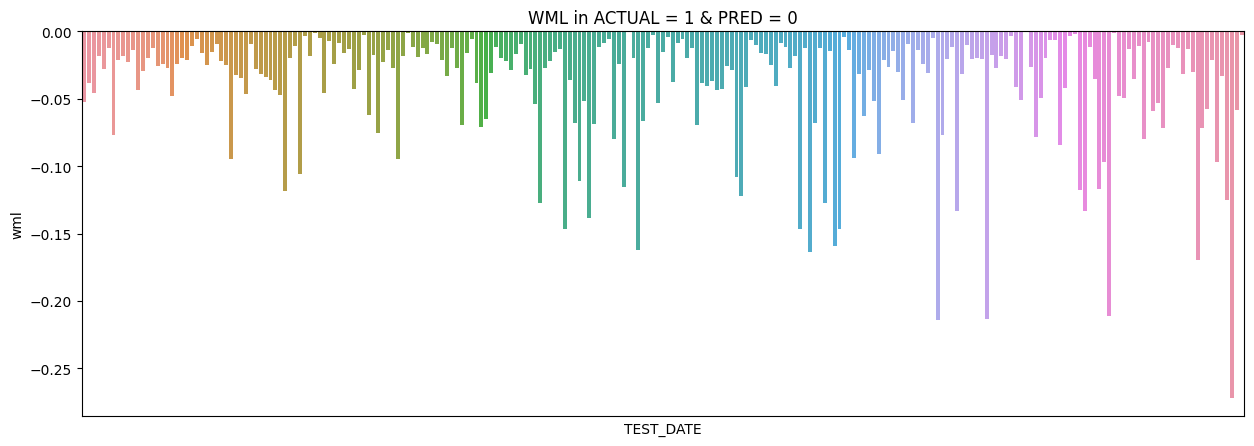

,count,mean,var,std,min,1%,25%,50%,75%,99%,max
wml,237.0,-0.041907,0.001963,0.044305,-0.271971,-0.212701,-0.051231,-0.026563,-0.013339,-0.000999,-0.000183


In [ ]:
plot_predict_result(Fixed_ISO_Result)

## Distribution

In [ ]:
plot_dynamic_momentum(Fixed_ISO_Result)